<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/04_MAB_movielens_thompson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Arm Bandits - Thompson Sampling

Thompson Sampling is a straightforward yet effective method to addressing the exploration-exploitation dilemma in reinforcement/online learning. Up until now, all of the techniques we’ve seen for tackling the Bandit Problem have selected actions based on the current averages of the rewards received. Thompson Sampling (also sometimes referred to as the Bayesian Bandits algorithm) takes a slightly different approach; rather than just refining an estimate of the mean reward, it extends this to instead build up a probability model from the obtained rewards then samples from this to choose an action.

#### Installation

In [1]:
!rm -f ./utils.py
!wget --no-check-certificate --no-cache --no-cookies \
    https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py \
    -O ./utils.py

--2021-02-25 14:40:27--  https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4245 (4.1K) [text/plain]
Saving to: ‘./utils.py’

./utils.py          100%[===================>]   4.15K  --.-KB/s    in 0s      

2021-02-25 14:40:27 (45.6 MB/s) - ‘./utils.py’ saved [4245/4245]



##### Imports

In [2]:
from scipy.stats import norm
from tqdm.notebook import trange
from typing import Any, Dict, List, Text, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import zipfile

from utils import load_movielens_data
from utils import plot_actions, plot_cumsum, plot_pdf, plot_regret

# Apply the default theme
sns.set_theme()

#### Downloading the [MovieLens](https://grouplens.org/datasets/movielens/) (100K) dataset.

**Dataset info**

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.

This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th,
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.

In [3]:
print("Downloading movielens data...")

!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-100k.zip \
    -O ./movielens.zip

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode())

--2021-02-25 14:40:27--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘./movielens.zip’

./movielens.zip     100%[===================>]   4.70M  27.8MB/s    in 0.2s    

2021-02-25 14:40:28 (27.8 MB/s) - ‘./movielens.zip’ saved [4924029/4924029]

Done. Dataset contains:
943 users
1682 items
100000 ratings



#### Parameters -- Feel Free to Play Around

In [4]:
RANK_K = 20 # @param {type:"integer"}
NUM_ACTIONS = 20 # @param {type:"integer"}

## Environment

Implementation of the environment uses **MovieLens 100K dataset**. As described above, the dataset contains 100000 ratings from 943 users and 1682 movies. The environment can consider only the first $n$ of the dataset's movies. It can be set-up by `num_actions`. The number of "known" movies for the environment is equal to actions/arms.

> Users without a rating (after selecting first $n$ movies) are removed from the environment.

> In every step, the batch of users will be selected randomly.

In [5]:
class MovielensEnvironment(object):
  def __init__(
      self, 
      data_dir: Text,
      rank_k: int, 
      batch_size: int = 1,
      num_movies: int = 20
  ):
    """Initializes the MovieLens Bandit environment.
    Args:
      data_dir: (string) Directory where the data lies (in text form).
      rank_k : (int) Which rank to use in the matrix factorization.
      batch_size: (int) Number of observations generated per call.
      num_movies: (int) Only the first `num_movies` movies will be used by the
        environment. The rest is cut out from the data.
    """
    self._num_actions = num_movies
    self._batch_size = batch_size
    self._context_dim = rank_k

    # Compute the matrix factorization.
    self._data_matrix = load_movielens_data(data_dir)
    # Keep only the first items.
    self._data_matrix = self._data_matrix[:, :num_movies]
    # Filter the users with no iterm rated.
    nonzero_users = list(np.nonzero(np.sum(self._data_matrix, axis=1) > 0.0)[0])
    self._data_matrix = self._data_matrix[nonzero_users, :]
    self._effective_num_users = len(nonzero_users)

    # Compute the SVD.
    u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)
    # Keep only the largest singular values.
    self._u_hat = u[:, :rank_k] * np.sqrt(s[:rank_k])
    self._v_hat = np.transpose(
        np.transpose(vh[:rank_k, :]) * np.sqrt(s[:rank_k]))
    self._approx_ratings_matrix = np.matmul(self._u_hat, self._v_hat)

    self._current_users = np.zeros(batch_size)
    self._previous_users = np.zeros(batch_size)

    self._optimal_action_table = np.argmax(
        self._approx_ratings_matrix, axis=1)
    self._optimal_reward_table = np.max(
        self._approx_ratings_matrix, axis=1)
    
    #self._params = params
    #self._observe()
    self.reset()

  @property
  def batch_size(self):
    return self._batch_size

  @property
  def best_action(self) -> int:
    return np.argmax(np.sum(env._data_matrix, axis=0))

  @property
  def n_actions(self) -> int:
    return self._data_matrix.shape[1]

  def reset(self):
    return self._observe()

  def _observe(self) -> np.ndarray:
    """Returns the u vectors of a random sample of users."""
    sampled_users = random.sample(
        range(self._effective_num_users), self._batch_size)
    self._previous_users = self._current_users
    self._current_users = sampled_users
    batched_observations = self._u_hat[sampled_users]
    return batched_observations

  def step(self, action: List[int]) -> Tuple[int, float]:
    """Computes the reward for the input actions."""
    rewards = []
    for i, j in zip(self._current_users, action):
      rewards.append(self._approx_ratings_matrix[i, j])
    return np.array(rewards)
  
  def best_action(self):
    return np.argmax(self._params)

  def compute_optimal_action(self):
    return self._optimal_action_table[self._previous_users]

  def compute_optimal_reward(self):
    return self._optimal_reward_table[self._previous_users]

Now we are equipped to initialize our environment.

In [6]:
env = MovielensEnvironment(
    './ml-100k/u.data', rank_k=RANK_K, batch_size=1, num_movies=NUM_ACTIONS)

Below we can check what this environment produces.

In [7]:
env.reset()

action = np.zeros(1, dtype=np.int32)
reward = env.step(action)

print(f'Action={action} (optimal={env.compute_optimal_action()})')
print(f'Reward={reward} (optimal={env.compute_optimal_reward()})')

Action=[0] (optimal=[0])
Reward=[2.09460706e-14] (optimal=[5.])


## Policy


The Thompson sampling algorithm simply samples actions according to the posterior probability they are optimal. In particular, actions are chosen randomly at time $t$ according to the sampling distribution $\pi_{t}^{TS} = \mathbb{P}(A^{\ast} = ·| \mathcal{F}_{t} )$. By definition, this means that for each $a \in \mathcal{A}$, $\mathbb{P}(A_{t} = a|\mathcal{F}_{t}) = \mathbb{P}(A^{\ast} = a|\mathcal{F}_{t})$. This algorithm is sometimes called probability matching because the action selection distribution is matched to the posterior distribution of the optimal action.

In our example, we use Normal distribussion for actions, i.e.,

$$
\hat{a}_{t}^{\ast} = \mathcal{N}\left(\mu, \sigma^{2} \right) = \mathcal{N}\left(\mu_{0}, \frac{1}{\tau_{0}} \right)
$$

**TASK**: Add code for sample batch of the actions.

In [8]:
class GaussianPolicy(object):
  def __init__(self, tau: List[float], mu: List[float], batch_size: int = 1):
    self._tau0 = tau
    self._mu0 = mu
    self._n = len(tau)
    self._batch_size = batch_size

  def action(self) -> int:
    sample = (np.random.randn(self._batch_size, self._n) / np.sqrt(self._tau0)) + self._mu0
    return np.argmax(sample, axis=1)

Below we can check what this policy produces.

In [9]:
p = GaussianPolicy([1, 10, 5], [1, 1, 1], batch_size=10)
print(f'GaussianPolicy - action: {p.action()}')

GaussianPolicy - action: [1 1 0 1 0 2 0 0 0 0]


## Agent

The primary function of the agent is to update policy parameters. In case of Thompson sampling, it is mainly update $\mu_{0}$ and $\tau_{0}$

$$
\tau_{0} \leftarrow \tau_{0} + n\tau, \\
\mu_{0} \leftarrow \frac{\tau_{0}\mu_{0} + \tau Q}{\tau_{0} + n\tau},
$$

where

* $\tau$ is the precision of the action, which in our case is just $1$,
* $n$ is the number of times that action $a$ has been selected,
* $Q$ is estimated value of action $a$ at time step $t$,
* $\mu_{0}$ is the estimated mean (the mean of the distribution used to model the output),
* $\tau_{0}$ is the precision of the distribution used to model the output.

**TASK**: Add code for updating distribution parameters $\mu_{0}$ and $\tau_{0}$.

In [10]:
class GaussianThompsonSamplingAgent(object):
  
  def __init__(self, n: int, batch_size: int = 1):
    self._batch_size = batch_size
    self._n = n

    self.reset()

    self.policy = GaussianPolicy(self._tau0, self._mu0, batch_size=batch_size)

  def reset(self):
    self._tau0 = [0.0001] * self._n
    self._mu0 = [1] * self._n
    self._Q = [0] * self._n

    self._counts = [0] * self._n
    self._values = [0.0] * self._n

  def train(self, experience: Dict[str, float]):
    """Update policy parameters.

    Args:
      experience: dictionary with a single action and reward
    """
    action = experience['action']
    reward = experience['reward']
    # Update average/mean value/reward for chosen action
    self._Q[action] += reward
    self._counts[action] += 1
    value = self._values[action]
    n = self._counts[action]
    self._values[action] = ((n - 1) / n) * value + (1 / n) * reward

    tau0 = self._tau0[action]
    mu0 = self._mu0[action]
    #Q = self._Q[action] / self._counts[action]
    Q = self._Q[action]
    
    #self._mu0[action] = ((tau0 * mu0) + (n * Q)) / (tau0 + n)        
    self._mu0[action] = ((tau0 * mu0) + Q) / (tau0 + n)        
    self._tau0[action] += 1

Below we can check how the training affects rewards estimation.

In [11]:
a = GaussianThompsonSamplingAgent(3, batch_size=1)

experience = {'action': 2, 'reward': 1}
a.train(experience)
print(f'Q={a._values}')
print(f'tau={a._tau0}')

experience = {'action': 2, 'reward': 0}
a.train(experience)
print(f'Q={a._values}')
print(f'tau={a._tau0}')

Q=[0.0, 0.0, 1.0]
tau=[0.0001, 0.0001, 1.0001]
Q=[0.0, 0.0, 0.5]
tau=[0.0001, 0.0001, 2.0000999999999998]


## Training

Now we put together all the components that we introduced above: the environment, the policy, and the agent. We run the policy on the environment and output training data.

In [12]:
def run(environment: object, agent: object, trials=100):
  trajectory = []

  experience = {'trial': 0, 'action': -1, 'observation': 0, 'reward': 0}

  for i in range(trials):
    experience['trial'] = i + 1
    actions = agent.policy.action()
    rewards = environment.step(actions)
    optimal_rewards = environment.compute_optimal_reward()

    for action, reward, optimal_reward in zip(actions, rewards, optimal_rewards):
      experience['action'] = action
      experience['reward'] = reward
      experience['regret'] = optimal_reward - reward

      agent.train(experience)

      trajectory.append(experience.copy())
    
  df_trajectory = pd.DataFrame.from_dict(trajectory)
  df_cumsum = df_trajectory.groupby('action')['reward'].cumsum()
  df_trajectory = df_trajectory.assign(cum_sum=df_trajectory['reward'].cumsum())
  df_trajectory = df_trajectory.assign(action_cum_sum=df_cumsum)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'})

Down below is the code for creating all necessary instances. We have here a few parameters we can play with. `num_iterations` specifies how many times we run the trainer loop, `batch_size` defines how many actions are generated through one step.

In [13]:
batch_size =   32 # @param {type:"integer"}
num_iterations =   150 # @param {type:"integer"}

environment = MovielensEnvironment(
  './ml-100k/u.data', 
  rank_k=RANK_K, 
  batch_size=batch_size, 
  num_movies=NUM_ACTIONS
)
step = environment.reset()

agent = GaussianThompsonSamplingAgent(
    environment.n_actions, 
    batch_size=environment.batch_size)
experience = {'action': [-1], 'reward': [0]}

df_trajectory = run(environment, agent, trials=num_iterations)

print(f'\Q={agent._values}')
print(f'N={agent._counts}')
print(f'best action={np.argmax(agent._values)}')

\Q=[2.241830065359493, 0.6999999999999912, 0.8571428571428548, 1.1428571428571326, 0.3333333333333279, -5.039354193947679e-16, 2.557821604661585, 0.666666666666662, 1.5909090909091008, 1.5237142875453124e-15, -1.0069889928352615e-14, 1.714285714285691, 0.8000000000000046, 1.0000000000000195, 2.019230769230788, 3.2706858234535095e-15, 0.3529411764705818, 1.5309129217764013e-16, 7.86384460515258e-15, 1.311916058405624e-15]
N=[153, 10, 7, 14, 3, 3, 4462, 3, 22, 7, 3, 21, 5, 4, 52, 3, 17, 2, 7, 2]
best action=6


Now let's see the result. After running the last code snippet, the resulting plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

In [14]:
params = {
    'mu': np.array(agent._mu0), 
    'tau': np.array(agent._tau0),
    'dist': 'Normal',
    'algorithm': 'Thompson Sampling'
}

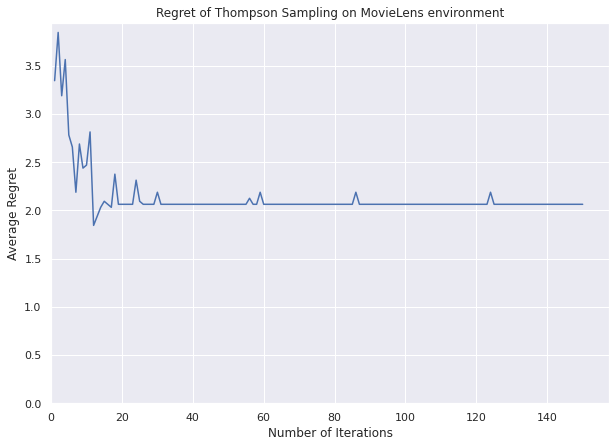

In [15]:
plot_regret(df_trajectory.groupby('trial').mean()['regret'], params)

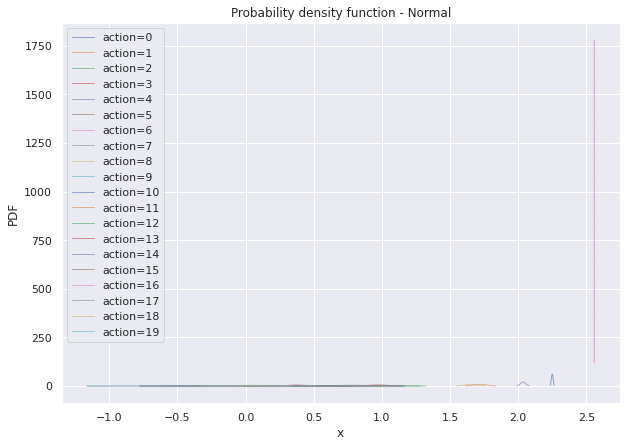

In [16]:
plot_pdf(params, type=1)

Let's see the selection's rate of the actions during the experiment.

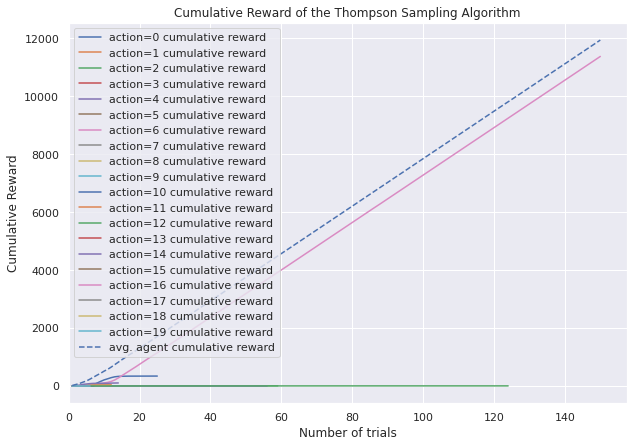

In [17]:
plot_cumsum(df_trajectory, params, show_actions=True)

#### Multiple runs

Because our environment selects users randomly, each run can produce different results. Let's what are the average results through multiple runs.

In [18]:
def experiment(epochs: int = 1, trials: int = 10, batch_size: int = 1):
  trajectories = []
  
  environment = MovielensEnvironment(
      './ml-100k/u.data', 
      rank_k=RANK_K, 
      batch_size=batch_size, 
      num_movies=NUM_ACTIONS)
  params = {
      'best_action': environment.best_action,
      'mu': [],
      'tau': [],
  }
  
  for epoch in trange(epochs):
    step = environment.reset()
    agent = GaussianThompsonSamplingAgent(
        environment.n_actions, batch_size=environment.batch_size)
    
    df = run(environment, agent, trials=trials)
    df['epoch'] = epoch + 1

    params['mu'].append(agent._mu0)
    params['tau'].append(agent._tau0)

    trajectories.append(df)

  df_trajectory = pd.concat(trajectories, ignore_index=True)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'}), params

Compared to a single run, we have one extra parameter. `epochs` controls the number of independent runs of the training loop.

In [25]:
batch_size =   32# @param {type:"integer"}
epochs =  25# @param {type: "integer"}
num_iterations =   100# @param {type:"integer"}

df_trajectory, params = experiment(
    epochs=epochs, 
    trials=num_iterations, 
    batch_size=batch_size
)

Now let's see the average results after running multiple runs. The resulting regret plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

In [26]:
params = {
    'mu': np.array(params['mu']).mean(axis=0), 
    'tau': np.array(params['tau']).mean(axis=0),
    'dist': 'Normal',
    'algorithm': 'Thompson Sampling'
}

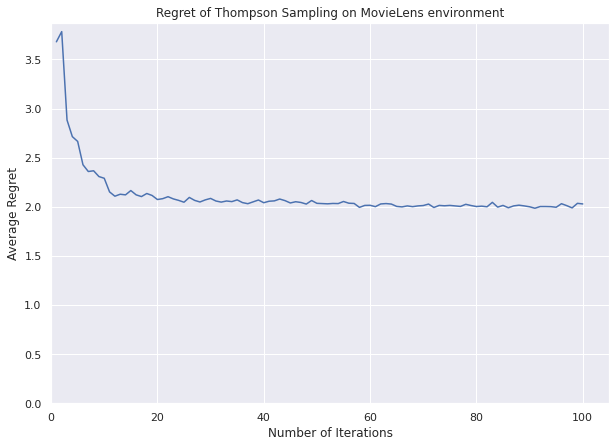

In [27]:
plot_regret(df_trajectory.groupby('trial').mean()['regret'], params)

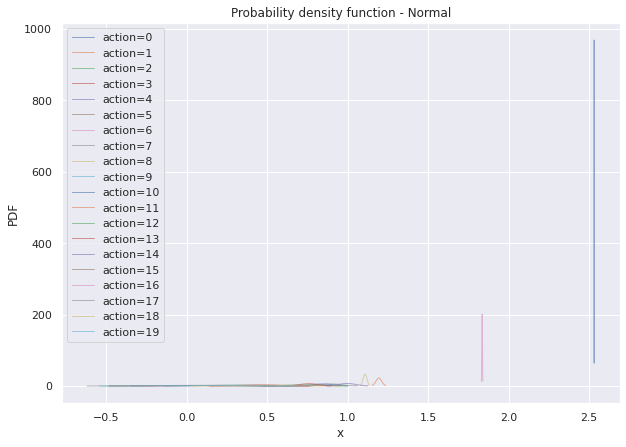

In [28]:
plot_pdf(params, type=1)

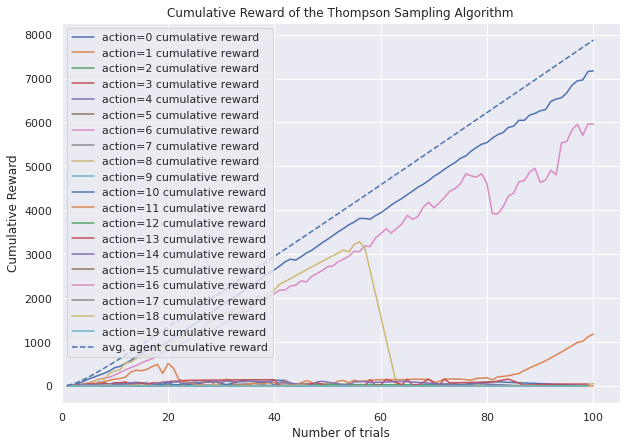

In [29]:
plot_cumsum(df_trajectory, params, show_actions=True)

Let's see the selection's rate of the actions during the experiment.

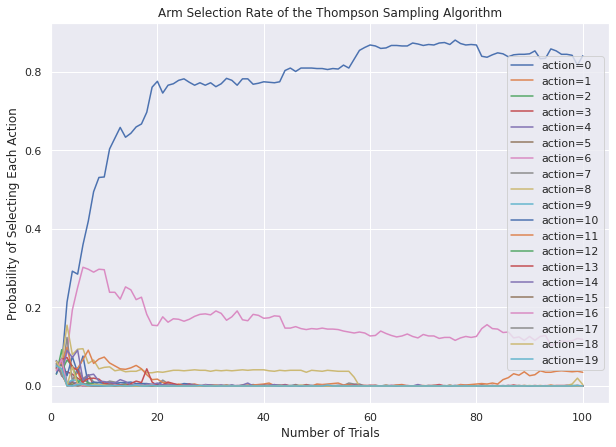

In [30]:
plot_actions(df_trajectory, params)